In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# prompt: unzip file

!unzip /content/drive/MyDrive/project_experiment_1.v2i.tensorflow.zip -d /content/drive/MyDrive/HSMain/IMAGES


Archive:  /content/drive/MyDrive/project_experiment_1.v2i.tensorflow.zip
 extracting: /content/drive/MyDrive/HSMain/IMAGES/README.dataset.txt  
 extracting: /content/drive/MyDrive/HSMain/IMAGES/README.roboflow.txt  
   creating: /content/drive/MyDrive/HSMain/IMAGES/test/
 extracting: /content/drive/MyDrive/HSMain/IMAGES/test/1_apple_1053_0990_jpg.rf.1ee5f20ab85b4535f4b1bfda2dbced34.jpg  
 extracting: /content/drive/MyDrive/HSMain/IMAGES/test/1_apple_107_0090_jpg.rf.6cb495d992215fe2e0cd1d952264dae1.jpg  
 extracting: /content/drive/MyDrive/HSMain/IMAGES/test/1_apple_107_0165_jpg.rf.fe86e1be9b9400a923b457df08c0c2ac.jpg  
 extracting: /content/drive/MyDrive/HSMain/IMAGES/test/1_apple_107_0180_jpg.rf.95697d9fb1da2f678f2bb0f60af206bf.jpg  
 extracting: /content/drive/MyDrive/HSMain/IMAGES/test/1_apple_107_0255_jpg.rf.d519a24c9ff0c5fd1da79b32db682839.jpg  
 extracting: /content/drive/MyDrive/HSMain/IMAGES/test/1_apple_107_0360_jpg.rf.7cb3a6456f0bd4534268fd48a8179c6e.jpg  
 extracting: /conte

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
from google.colab.patches import cv2_imshow
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import img_to_array, load_img, to_categorical
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout,Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

In [ ]:
class Config:
    BASE_PATH = '/content/drive/MyDrive/HSMain/'
    TRAIN_CSV_PATH = os.path.join(BASE_PATH, 'CSV/train/')
    VALID_CSV_PATH = os.path.join(BASE_PATH, 'CSV/valid/')
    TEST_CSV_PATH = os.path.join(BASE_PATH, 'CSV/test/')
    TRAIN_IMAGES_PATH = os.path.join(BASE_PATH, 'IMAGES/train/')
    VALID_IMAGES_PATH = os.path.join(BASE_PATH, 'IMAGES/valid/')
    TEST_IMAGES_PATH = os.path.join(BASE_PATH, 'IMAGES/test')
    IMG_HEIGHT = 224
    IMG_WIDTH = 224
config = Config()



In [ ]:
def get_data(csv_path, images_path, height, width):
    images = []
    labels = []
    bboxes = []

    csv_files = [f for f in os.listdir(csv_path) if f.endswith('.csv')]

    for csv_file in csv_files:
        csv_file_full_path = os.path.join(csv_path, csv_file)
        df = pd.read_csv(csv_file_full_path)

        for _, row in df.iterrows():
            filename = row[0]
            x1, y1, x2, y2 = row[2], row[3], row[4], row[5]
            label = row[1]
            image_full_path = os.path.join(images_path, filename)  # Thay đổi ở đây

            image = cv2.imread(image_full_path)

            if image is not None:
                (h, w, _) = image.shape

                x1_normalized = float(x1) / w
                y1_normalized = float(y1) / h
                x2_normalized = float(x2) / w
                y2_normalized = float(y2) / h

                image = cv2.resize(image, (width, height))
                image = img_to_array(image) / 255.0

                images.append(image)
                labels.append(label)
                bboxes.append([x1_normalized, y1_normalized, x2_normalized, y2_normalized])
            else:
                print(f"File not found: {image_full_path}")

    return np.array(images), np.array(labels), np.array(bboxes)

train_images, train_labels, train_bboxes = get_data(config.TRAIN_CSV_PATH, config.TRAIN_IMAGES_PATH, config.IMG_HEIGHT, config.IMG_WIDTH)
valid_images, valid_labels, valid_bboxes = get_data(config.VALID_CSV_PATH, config.VALID_IMAGES_PATH, config.IMG_HEIGHT, config.IMG_WIDTH)
test_images, test_labels, test_bboxes = get_data(config.TEST_CSV_PATH, config.TEST_IMAGES_PATH, config.IMG_HEIGHT, config.IMG_WIDTH)

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

def preprocess_input(images, labels, bboxes):
    images = np.array(images, dtype=np.float32) / 255.0

    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(labels)

    labels = to_categorical(integer_encoded)

    bboxes = np.array(bboxes, dtype=np.float32)

    return images, labels, bboxes, label_encoder.classes_

train_images, train_labels, train_bboxes, class_labels = preprocess_input(train_images, train_labels, train_bboxes)
valid_images, valid_labels, valid_bboxes, _ = preprocess_input(valid_images, valid_labels, valid_bboxes)
test_images, test_labels, test_bboxes, _ = preprocess_input(test_images, test_labels, test_bboxes)

print(f"Training data: {len(train_images)}")
print(f"Validation data: {len(valid_images)}")
print(f"Test data: {len(test_images)}")
print(f"Class labels: {class_labels}")


Training data: 2167
Validation data: 619
Test data: 310
Class labels: ['Apple' 'Banana' 'Orange' 'Tomato' 'Watermelon']


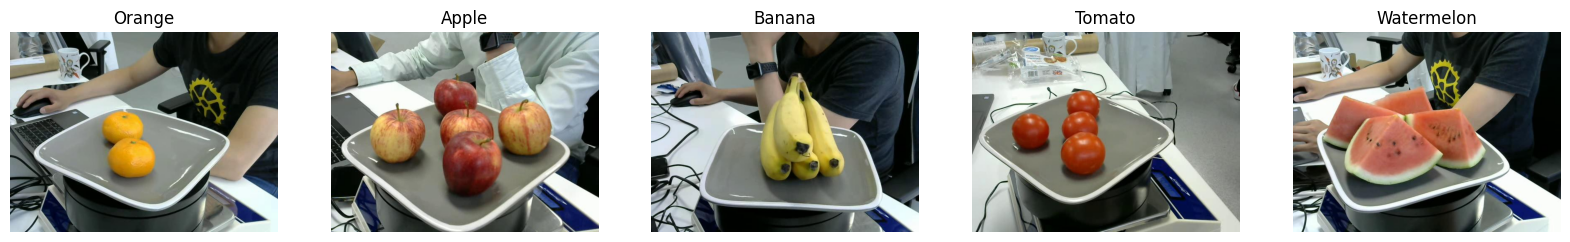

In [ ]:
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import re

# Đường dẫn đến tệp CSV
csv_file_path = '/content/drive/MyDrive/HSMain/CSV/test/_annotations.csv'
# Đường dẫn đến thư mục chứa ảnh
images_path = '/content/drive/MyDrive/HSMain/IMAGES/test/'

# Đọc tệp CSV
df = pd.read_csv(csv_file_path)

# Lấy tất cả các số bắt đầu tên tệp
start_numbers = df['filename'].apply(lambda x: re.match(r'^\d+', x).group())

# Chọn 5 số bắt đầu khác nhau
unique_start_numbers = start_numbers.unique()[:5]

# Tạo một lưới ảnh 1x5
fig, axs = plt.subplots(1, 5, figsize=(20, 4))

# Hiển thị mỗi ảnh được chọn
for i, start_number in enumerate(unique_start_numbers):
    # Lấy tên ảnh từ hàng
    image_row = df[df['filename'].str.startswith(start_number)].iloc[0]
    image_name = image_row['filename']
    image_label = image_row['class']
    # Lấy đường dẫn đầy đủ của ảnh
    image_full_path = os.path.join(images_path, image_name)
    # Đọc ảnh từ đường dẫn
    image = cv2.imread(image_full_path)

    # Kiểm tra xem ảnh có tồn tại không
    if image is not None:
        # Hiển thị ảnh trên subplot thứ i
        axs[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Chuyển đổi từ BGR sang RGB để hiển thị đúng
        axs[i].set_title(image_label)
        axs[i].axis('off')

plt.show()

In [ ]:
print(train_images.shape)
print(train_labels.shape)
print(train_bboxes.shape)

(2167, 224, 224, 3)
(2167, 5)
(2167, 4)


In [ ]:
model_CNN = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),

    Dense(5, activation='softmax')
])

model_CNN.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_CNN.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

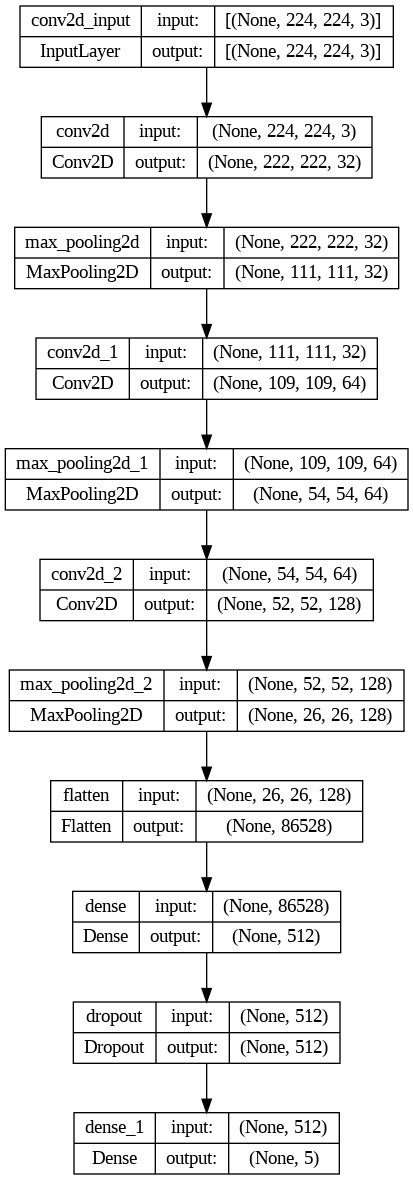

In [ ]:
plot_model(model_CNN, to_file='model_CNN_Class.png', show_shapes=True, show_layer_names=True)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

model_checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/HSMain/model/model_CNN_class.h5',
    save_best_only=True,
    verbose=1
)

history_CNN = model_CNN.fit(
train_images,
train_labels,
validation_data=(valid_images, valid_labels),
    batch_size=32,
    epochs=32,
    verbose=1,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/32
68/68 [==============================] - ETA: 0s - loss: 0.7657 - accuracy: 0.6959
Epoch 1: val_loss improved from inf to 0.02865, saving model to /content/drive/MyDrive/HSMain/model/model_CNN_class.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


68/68 [==============================] - 17s 135ms/step - loss: 0.7657 - accuracy: 0.6959 - val_loss: 0.0287 - val_accuracy: 0.9903
Epoch 2/32
68/68 [==============================] - ETA: 0s - loss: 0.0207 - accuracy: 0.9931
Epoch 2: val_loss improved from 0.02865 to 0.01381, saving model to /content/drive/MyDrive/HSMain/model/model_CNN_class.h5
68/68 [==============================] - 7s 105ms/step - loss: 0.0207 - accuracy: 0.9931 - val_loss: 0.0138 - val_accuracy: 0.9968
Epoch 3/32
67/68 [============================>.] - ETA: 0s - loss: 0.0136 - accuracy: 0.9958
Epoch 3: val_loss did not improve from 0.01381
68/68 [==============================] - 4s 66ms/step - loss: 0.0134 - accuracy: 0.9958 - val_loss: 0.0140 - val_accuracy: 0.9984
Epoch 4/32
68/68 [==============================] - ETA: 0s - loss: 0.0043 - accuracy: 0.9991
Epoch 4: val_loss did not improve from 0.01381
68/68 [==============================] - 5s 69ms/step - loss: 0.0043 - accuracy: 0.9991 - val_loss: 0.0187 -

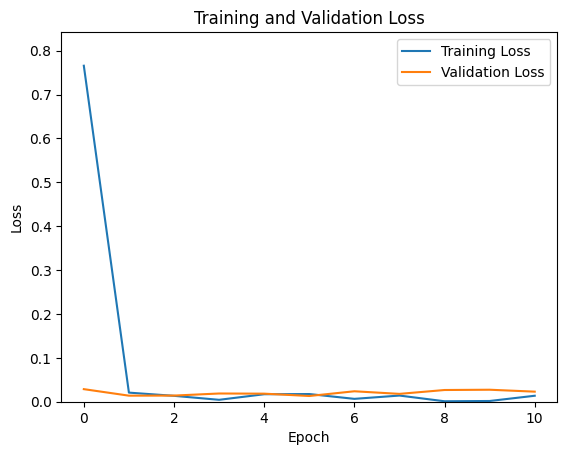

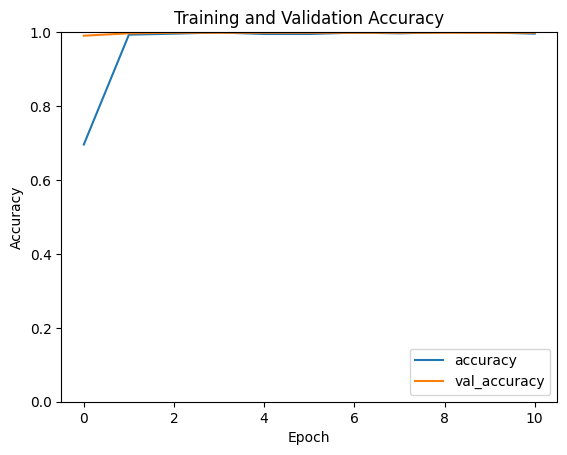

In [ ]:
# Vẽ biểu đồ loss trong quá trình huấn luyện
plt.plot(history_CNN.history['loss'], label='Training Loss')
plt.plot(history_CNN.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, max(max(history_CNN.history['loss']), max(history_CNN.history['val_loss'])) * 1.1])
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')
plt.show()

# Vẽ biểu đồ huấn luyện
plt.plot(history_CNN.history['accuracy'], label='accuracy')
plt.plot(history_CNN.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')
plt.show()


In [ ]:
model_MLP = Sequential([
    Flatten(input_shape=(224, 224, 3)),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])
model_MLP.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model_MLP.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense_2 (Dense)             (None, 512)               77070848  
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 77203461 (294.51 MB)
Trainable params: 7

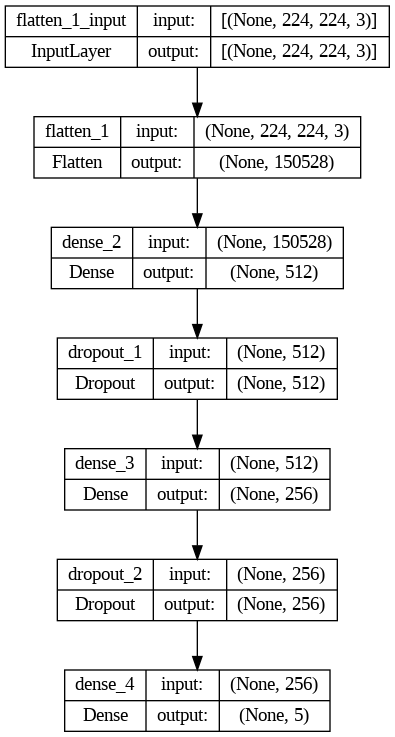

In [ ]:
plot_model(model_MLP, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

model_checkpoint = ModelCheckpoint(
    "/content/drive/MyDrive/HSMain/model/model_MLP_class.h5",
    save_best_only=True,
    verbose=1
)

history_MLP = model_MLP.fit(
    train_images,
    train_labels,
    validation_data=(valid_images, valid_labels),
    batch_size=32,
    epochs=32,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/32
67/68 [============================>.] - ETA: 0s - loss: 0.5060 - accuracy: 0.8116
Epoch 1: val_loss improved from inf to 0.03334, saving model to /content/drive/MyDrive/HSMain/model/model_MLP_class.h5
68/68 [==============================] - 11s 125ms/step - loss: 0.5009 - accuracy: 0.8136 - val_loss: 0.0333 - val_accuracy: 0.9952
Epoch 2/32
67/68 [============================>.] - ETA: 0s - loss: 0.0439 - accuracy: 0.9879
Epoch 2: val_loss improved from 0.03334 to 0.02145, saving model to /content/drive/MyDrive/HSMain/model/model_MLP_class.h5
68/68 [==============================] - 8s 121ms/step - loss: 0.0435 - accuracy: 0.9880 - val_loss: 0.0215 - val_accuracy: 0.9952
Epoch 3/32
67/68 [============================>.] - ETA: 0s - loss: 0.0295 - accuracy: 0.9911
Epoch 3: val_loss improved from 0.02145 to 0.01114, saving model to /content/drive/MyDrive/HSMain/model/model_MLP_class.h5
68/68 [==============================] - 19s 284ms/step - loss: 0.0294 - accuracy: 0.9912 

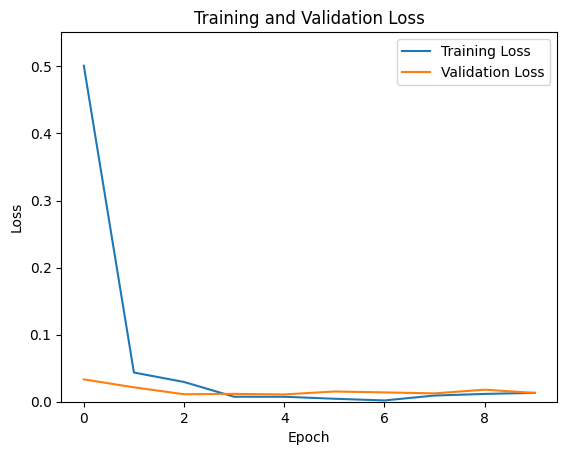

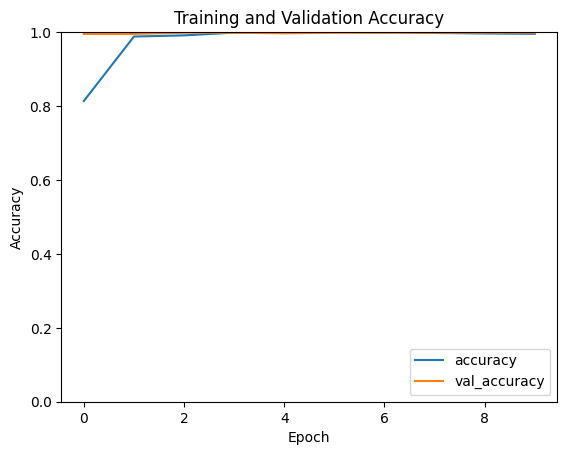

In [ ]:
# Vẽ biểu đồ loss trong quá trình huấn luyện
plt.plot(history_MLP.history['loss'], label='Training Loss')
plt.plot(history_MLP.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, max(max(history_MLP.history['loss']), max(history_CNN.history['val_loss'])) * 1.1])
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')
plt.show()

# Vẽ biểu đồ huấn luyện
plt.plot(history_MLP.history['accuracy'], label='accuracy')
plt.plot(history_MLP.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
# Tạo mô hình cơ sở ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Thêm các lớp tùy chỉnh
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)

model_resnet50 = Model(inputs=base_model.input, outputs=predictions)

model_resnet50.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model_resnet50.summary()

94765736/94765736 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                         

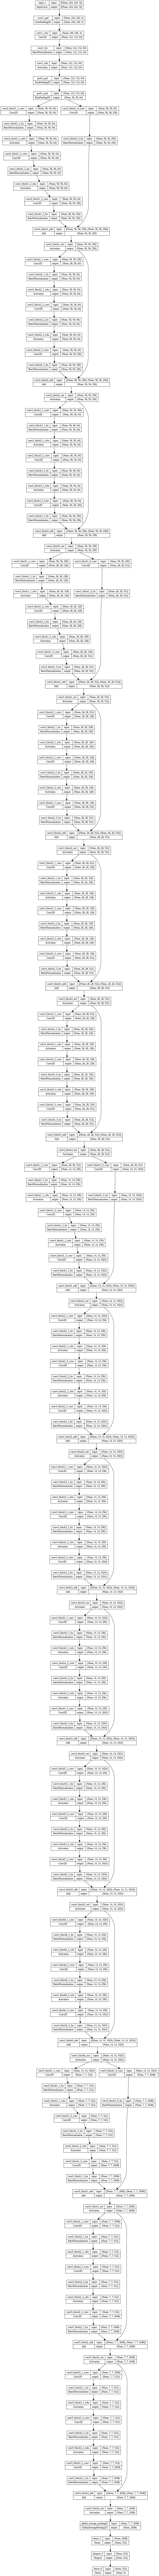

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_resnet50, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [ ]:
checkpoint = ModelCheckpoint("/content/drive/MyDrive/HSMain/model/resnet50_class.h5", save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

history_resnet = model_resnet50.fit(train_images, train_labels, batch_size=32,
                    epochs=20,
                    validation_data=(valid_images,valid_labels),
                    callbacks=[
                    checkpoint])


Epoch 1/20
68/68 [==============================] - ETA: 0s - loss: 1.6339 - accuracy: 0.2843

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


68/68 [==============================] - 41s 461ms/step - loss: 1.6339 - accuracy: 0.2843 - val_loss: 1.5561 - val_accuracy: 0.1890
Epoch 2/20
68/68 [==============================] - 10s 152ms/step - loss: 1.5339 - accuracy: 0.3013 - val_loss: 1.5070 - val_accuracy: 0.3360
Epoch 3/20
68/68 [==============================] - 14s 208ms/step - loss: 1.5217 - accuracy: 0.3221 - val_loss: 1.5038 - val_accuracy: 0.3360
Epoch 4/20
68/68 [==============================] - 10s 140ms/step - loss: 1.5179 - accuracy: 0.3244 - val_loss: 1.5059 - val_accuracy: 0.3360
Epoch 5/20
68/68 [==============================] - 9s 140ms/step - loss: 1.5117 - accuracy: 0.3253 - val_loss: 1.5112 - val_accuracy: 0.3360
Epoch 6/20
68/68 [==============================] - 9s 134ms/step - loss: 1.5265 - accuracy: 0.3198 - val_loss: 1.5053 - val_accuracy: 0.3360
Epoch 7/20
68/68 [==============================] - 9s 128ms/step - loss: 1.5161 - accuracy: 0.3299 - val_loss: 1.5044 - val_accuracy: 0.3360
Epoch 8/20
68

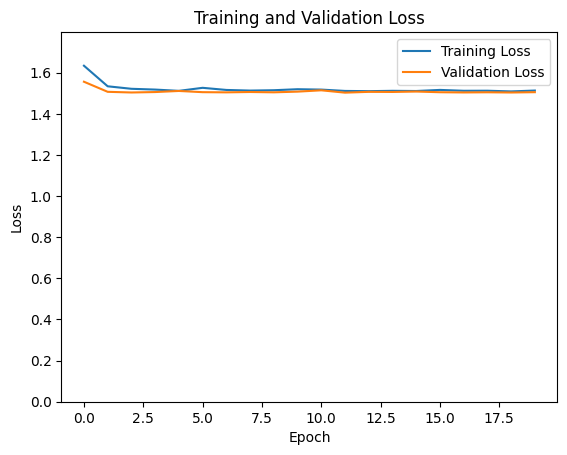

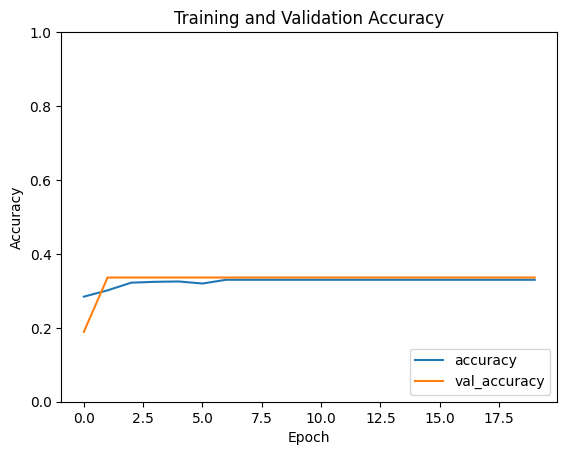

In [ ]:
# Vẽ biểu đồ loss trong quá trình huấn luyện
plt.plot(history_resnet.history['loss'], label='Training Loss')
plt.plot(history_resnet.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, max(max(history_resnet.history['loss']), max(history_resnet.history['val_loss'])) * 1.1])
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')
plt.show()

# Vẽ biểu đồ huấn luyện
plt.plot(history_resnet.history['accuracy'], label='accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
def get_model_cnn(height, width, channel, nclasses):
    inputs = Input(shape=input_shape)

    # Lớp tích chập và pooling
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    flat = Flatten()(x)

    class_output = Dense(256, activation='relu')(flat)
    class_output = Dropout(0.5)(class_output)
    class_output = Dense(nclasses, activation='softmax', name='class_output')(class_output)

    # Nhánh dự đoán bounding box
    bbox_output = Dense(128, activation='relu')(flat)
    bbox_output = Dropout(0.5)(bbox_output)
    bbox_output = Dense(64, activation='relu')(bbox_output)
    bbox_output = Dense(4, activation='sigmoid', name='bbox_output')(bbox_output)

    # Tạo model
    model = Model(inputs=inputs, outputs=[class_output, bbox_output])

    # Biên dịch mô hình
    model.compile(optimizer='adam',
                  loss={'class_output': 'categorical_crossentropy', 'bbox_output': 'binary_crossentropy'},
                  metrics={'class_output': 'accuracy', 'bbox_output': 'accuracy'},
                  loss_weights={'class_output': 1.0, 'bbox_output': 1.0})

    return model


input_shape = (224, 224, 3)
nclasses = 5
model_CNN = get_model_cnn(config.IMG_HEIGHT, config.IMG_WIDTH, 3, nclasses)

# In tổng quan mô hình
model_CNN.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 222, 222, 32)         896       ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_3 (MaxPoolin  (None, 111, 111, 32)         0         ['conv2d_3[0][0]']            
 g2D)                                                                                             
                                                                                                  
 dropout_4 (Dropout)         (None, 111, 111, 32)         0         ['max_pooling2d_3[0][0]'

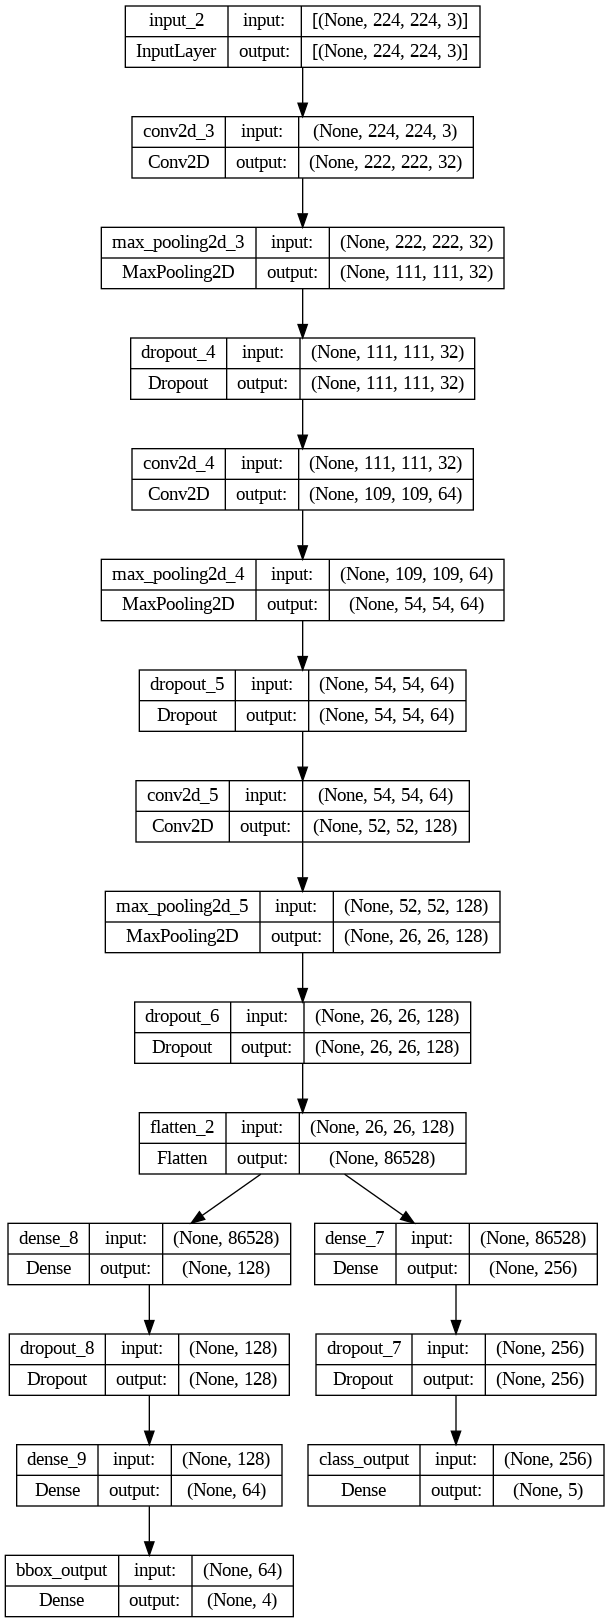

In [ ]:
plot_model(model_CNN, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [ ]:
nclasses = 5
model = get_model_cnn(config.IMG_HEIGHT, config.IMG_WIDTH, 3, nclasses)
train_images = np.stack(train_images)
train_labels = np.stack(train_labels)
train_bboxes = np.stack(train_bboxes)

valid_images = np.stack(valid_images)
valid_labels = np.stack(valid_labels)
valid_bboxes = np.stack(valid_bboxes)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    mode='min',
    restore_best_weights=True
)
model_checkpoint = ModelCheckpoint(
    "/content/drive/MyDrive/HSMain/model/CNN_OD.h5",
    save_best_only=True,
    verbose=1
)

# Train the model
H_CNN = model.fit(
    x=train_images,
    y={'class_output': train_labels, 'bbox_output': train_bboxes},
    validation_data=(valid_images, {'class_output': valid_labels, 'bbox_output': valid_bboxes}),
    batch_size=32,
    epochs=32,
    verbose=1,
     callbacks=[early_stopping, model_checkpoint]
)


print(H_CNN.history.keys())

Epoch 1/32
68/68 [==============================] - ETA: 0s - loss: 1.9719 - class_output_loss: 1.3814 - bbox_output_loss: 0.5905 - class_output_accuracy: 0.4209 - bbox_output_accuracy: 0.6114
Epoch 1: val_loss improved from inf to 1.16608, saving model to /content/drive/MyDrive/HSMain/model/CNN_OD.h5
68/68 [==============================] - 19s 230ms/step - loss: 1.9719 - class_output_loss: 1.3814 - bbox_output_loss: 0.5905 - class_output_accuracy: 0.4209 - bbox_output_accuracy: 0.6114 - val_loss: 1.1661 - val_class_output_loss: 0.5909 - val_bbox_output_loss: 0.5752 - val_class_output_accuracy: 0.8901 - val_bbox_output_accuracy: 0.6284
Epoch 2/32
68/68 [==============================] - ETA: 0s - loss: 0.6962 - class_output_loss: 0.1261 - bbox_output_loss: 0.5701 - class_output_accuracy: 0.9557 - bbox_output_accuracy: 0.6654
Epoch 2: val_loss improved from 1.16608 to 0.59237, saving model to /content/drive/MyDrive/HSMain/model/CNN_OD.h5
68/68 [==============================] - 12s 182

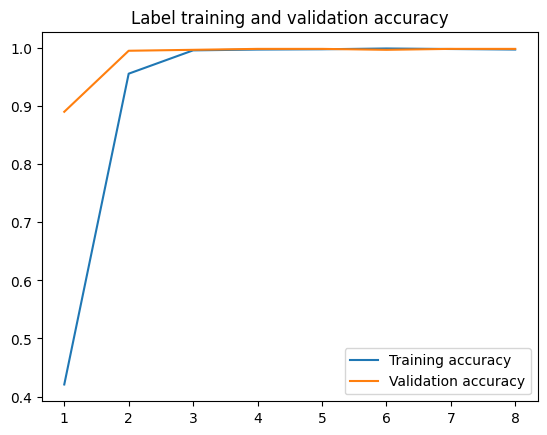

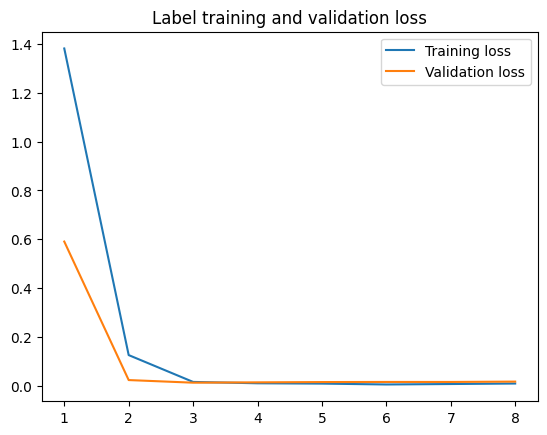

In [ ]:
plt.figure()
accuracy = H_CNN.history["class_output_accuracy"]
val_accuracy = H_CNN.history["val_class_output_accuracy"]

loss = H_CNN.history["class_output_loss"]
val_loss = H_CNN.history["val_class_output_loss"]

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, label="Training accuracy")
plt.plot(epochs, val_accuracy, label="Validation accuracy")
plt.title("Label training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.title("Label training and validation loss")
plt.legend()
plt.show()

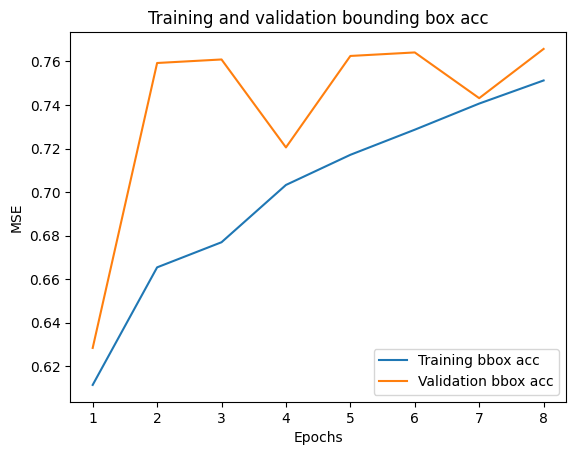

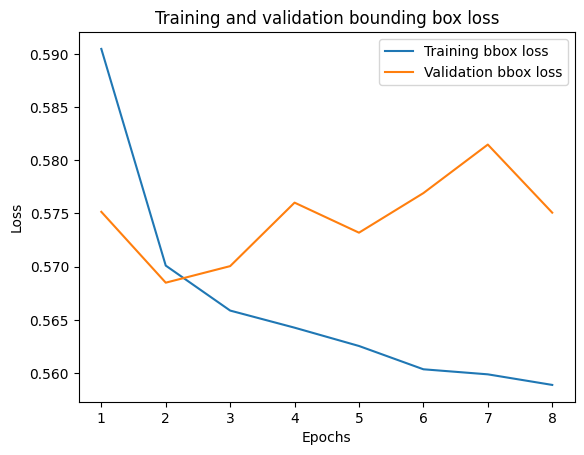

In [ ]:
plt.figure()
bbox_acc = H_CNN.history["bbox_output_accuracy"]
val_bbox_acc = H_CNN.history["val_bbox_output_accuracy"]

bbox_loss = H_CNN.history["bbox_output_loss"]
val_bbox_loss = H_CNN.history["val_bbox_output_loss"]

epochs = range(1, len(bbox_acc) + 1)

plt.plot(epochs, bbox_acc, label="Training bbox acc")
plt.plot(epochs, val_bbox_acc, label="Validation bbox acc")
plt.title("Training and validation bounding box acc")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.figure()

plt.plot(epochs, bbox_loss,  label="Training bbox loss")
plt.plot(epochs, val_bbox_loss, label="Validation bbox loss")
plt.title("Training and validation bounding box loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


Actual bounding box: [91, 167, 387, 317]
1/1 [==============================] - 0s 97ms/step


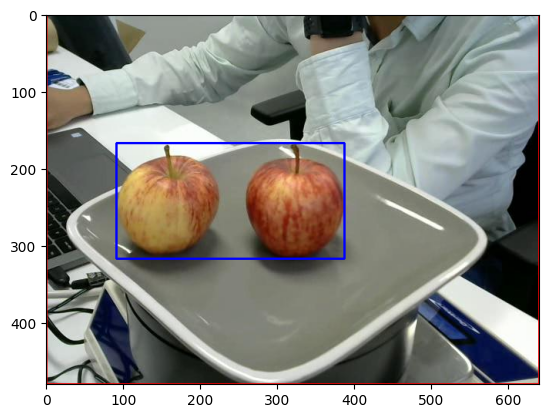

Class: Apple


In [ ]:
def get_actual_bbox_from_csv(csv_file_path, image_name):
    df = pd.read_csv(csv_file_path, header=None)

    bbox_row = df[df[0] == image_name]
    if not bbox_row.empty:
        actual_bbox = bbox_row[[2, 3, 4, 5]].values[0]
        # Convert the strings to integers
        actual_bbox = [int(x) for x in actual_bbox]
        return actual_bbox
    else:
        return None


csv_file_path = '/content/drive/MyDrive/HSMain/CSV/test/_annotations.csv'
image_name = '1_apple_206_1125_jpg.rf.618489c28178fd95b1283bb50e4bab12.jpg'

actual_bbox = get_actual_bbox_from_csv(csv_file_path, image_name)
print('Actual bounding box:', actual_bbox)

def predict_and_draw(image_path, model, actual_bbox, class_names):
    image = load_img(image_path, target_size=(224, 224))
    image_arr = img_to_array(image) / 255.0
    image_arr = np.expand_dims(image_arr, axis=0)

    preds = model.predict(image_arr)
    pred_label = np.argmax(preds[0][0])
    pred_bbox = preds[1][0]

    orig = cv2.imread(image_path)
    h, w = orig.shape[:2]
    pred_bbox = [int(pred_bbox[0] * w), int(pred_bbox[1] * h), int(pred_bbox[2] * w), int(pred_bbox[3] * h)]

    orig = cv2.rectangle(orig, (actual_bbox[0], actual_bbox[1]), (actual_bbox[2], actual_bbox[3]), (255, 0, 0), 2)
    orig = cv2.rectangle(orig, (pred_bbox[0], pred_bbox[1]), (pred_bbox[2], pred_bbox[3]), (0, 0, 255), 2)

    label = class_names[pred_label]
    cv2.putText(orig, label, (pred_bbox[0], pred_bbox[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)

    plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
    plt.show()
    print(f"Class: {label}")



model = load_model('/content/drive/MyDrive/HSMain/model/CNN_OD.h5')
image_path = '/content/drive/MyDrive/HSMain/IMAGES/test/1_apple_206_1125_jpg.rf.618489c28178fd95b1283bb50e4bab12.jpg'

class_names = {0: 'Apple', 1: 'Banana', 2: 'Orange', 3: 'Tomato', 4: 'Watermelon'}
predict_and_draw(image_path, model, actual_bbox, class_names)